In [6]:
#import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [7]:
#hs_2028_geo = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_files\\pu_with_proj_SPLIT.geojson').to_crs(epsg=3857)

#hs_full_geo contains the count, base and student gen for all planning units
hs_full_geo = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_files\\hs_full_geo.geojson').to_crs(epsg=3857)
hs_full_geo.head(2)

,pu_2324_84,X,Y,Region,Shape_Area,count,basez,student_gen,geometry
0,1,2.049028e+06,893128.606346,North,3.556198e+07,6.0,6.0,0,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+..."
1,2,2.039923e+06,835434.121317,North,2.080136e+07,18.0,8.0,0,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+..."


In [8]:
dps_base = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\dps_base_2324.geojson')
dps_base = dps_base.to_crs(epsg = 3857)
base_hs = {'Jordan High School','Riverside High School','Northern High School','Hillside High School','Southern High School'}
dps_base_hs = dps_base[dps_base['name'].isin(base_hs)]
dps_base_hs = dps_base_hs[['name','geometry']]
dps_base_hs.loc[5,'name']='New High School'
dps_base_hs = dps_base_hs.reset_index()

#df of current base high schools and their geographies

In [9]:
dps_pu = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_Files\\pu_2324_SPLIT.geojson').rename(columns={'pu_2324_848':'pu_2324_84'})
dps_pu = dps_pu.to_crs(epsg = 3857).sort_values(by='pu_2324_84')
dps_pu.head(2)

#df of all planning units

,OBJECTID,pu_2324_84,X,Y,M_min,PS_ID,PUID2122_2,ps_id_833,psid_982,TIMS_PU,Region,Shape_Length,Shape_Area,geometry
0,1,1,2.049028e+06,893128.606346,0.0,589,589,1,1,PU589,North,26532.120021,3.556198e+07,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+..."
1,2,2,2.039923e+06,835434.121317,0.0,401,401,2,2,PU401,North,19333.085511,2.080136e+07,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+..."


In [10]:
#precomputed stuff for function
school_names = ['Southern High School','Hillside High School','Northern High School','Riverside High School','Jordan High School','New High School']
capacities = [1340,1335,700,1640,1510,1550]

In [11]:
#local copies of dfs
local_hs_full_geo = hs_full_geo.copy()
local_dps_base_hs = dps_base_hs.copy()

In [7]:
#same for ms

single_reg = dps_base[~dps_base['region_base'].isin(['district-wide','regional (SW, SE, C)'])]
dps_base_ms = single_reg[single_reg['name'].str.contains('Middle School')]
local_dps_base_ms = dps_base_ms.copy()
local_dps_base_ms = local_dps_base_ms[['name','geometry']].reset_index()

In [8]:
ms_full_geo = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_files\\ms_full_geo.geojson').to_crs(epsg=3857)
local_ms_full_geo = ms_full_geo.copy()

In [12]:
school_names = ['Shepard Middle School','Lakewood Montessori Middle School','Neal Middle School','Lowes Grove Middle School','Brogden Middle School','Carrington Middle School','Lucas Middle School','Githens Middle School','New Middle School']
capacities = [396,160,810,774,872,850,644,900,700]

In [53]:
def score_candidate(candidate,sgr,lower_bound,upper_bound):
    i=0
    counts = pd.DataFrame({'school':school_names,
                           'capacity':capacities,
                           'count':[0,0,0,0,0,0,0,0,0],
                           'adjust':[0,0,0,0,0,0,0,0,0]
                            })                              

    
    candidate_geom = candidate['geometry']
    local_dps_base_ms.loc[8,'geometry']=candidate_geom.centroid
    counts['pct_capacity'] = counts['count']/counts['capacity']
    
    
    while ((counts['pct_capacity']<lower_bound/100)|(counts['pct_capacity']>upper_bound/100)).any() and i<=150:                                    
        assignments = []
        for pu in local_ms_full_geo.itertuples(index=False):                   
            centroid = pu.geometry.centroid
            pu_scores = []
            for j in range(9):    
                dist = centroid.distance(local_dps_base_ms.loc[j,'geometry'])
                score = dist + counts.loc[j,'adjust']
                pu_scores.append(score)
            assign = school_names[pu_scores.index(min(pu_scores))]
            assignments.append(assign)
        local_ms_full_geo['assign'] = assignments
    
        for j,school in enumerate(school_names):
            assigned_students = int(local_ms_full_geo.loc[local_ms_full_geo['assign'] == school, 'basez'].sum() + local_ms_full_geo.loc[local_ms_full_geo['assign'] == school, 'student_gen'].sum()*sgr/100)
            counts.loc[j, 'count'] = assigned_students  
                
            if counts.loc[j,'count'] <= counts.loc[j,'capacity']*lower_bound/100:
                counts.loc[j,'adjust'] -= 200
            elif counts.loc[j,'count'] >= counts.loc[j,'capacity']*upper_bound/100:
                counts.loc[j,'adjust'] += 200
            else:
                pass
        counts['pct_capacity'] = counts['count']/counts['capacity']
        i+=1

    if i<=150:
        objective=local_ms_full_geo.merge(local_dps_base_ms,left_on='assign',right_on='name',how='left')
        objective['distance']=objective['geometry_x'].distance(objective['geometry_y'])
        objective_score = ((objective['basez']+sgr*objective['student_gen']/100)*objective['distance']).sum()/(10**7)
        return str(i)+' trials',objective_score,counts
    else:
        return 'Failed to set boundaries within 150 tries. Try again with different capacity bounds.',counts

In [54]:
candidate = local_ms_full_geo.loc[123]
score_candidate(candidate,20,70,100)

('25 trials',
 1.8723173367930337,
                               school  capacity  count  adjust  pct_capacity
 0              Shepard Middle School       396    374    4000      0.944444
 1  Lakewood Montessori Middle School       160    145    4600      0.906250
 2                 Neal Middle School       810    750     400      0.925926
 3          Lowes Grove Middle School       774    556   -2400      0.718346
 4              Brogden Middle School       872    818    3200      0.938073
 5           Carrington Middle School       850    666   -1000      0.783529
 6                Lucas Middle School       644    513   -3000      0.796584
 7              Githens Middle School       900    786   -1200      0.873333
 8                  New Middle School       700    499   -4200      0.712857)

<Axes: title={'center': 'Expanded HS Boundaries'}>

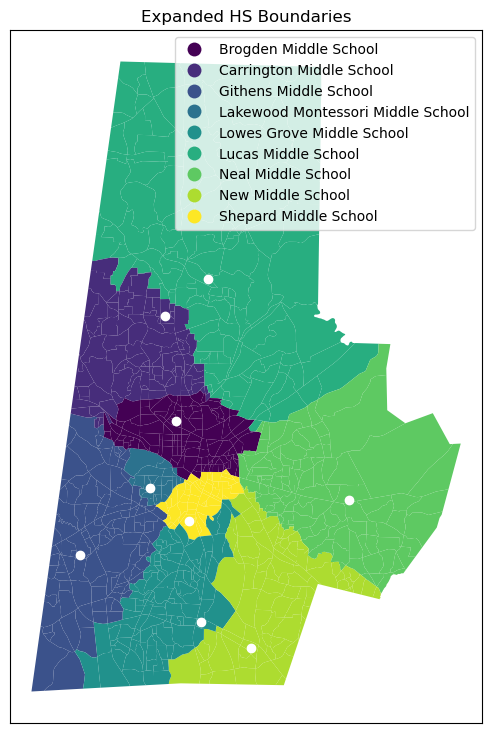

In [55]:
fig,ax = plt.subplots(figsize = (7,9))

local_ms_full_geo.plot(
    column='assign',
    ax = ax,
    cmap = 'viridis',
    legend = True
)

ax.set_xticks([])
ax.set_yticks([])

plt.title('Expanded HS Boundaries')
local_dps_base_ms.plot(ax=plt.gca(), color = 'white')

In [12]:
#boundary siting and scoring algorithm
def score_candidate(candidate,sgr,lower_bound,upper_bound):
    i=0
    counts = pd.DataFrame({'school':school_names,
                           'capacity':capacities,
                           'count':[0,0,0,0,0,0],
                           'adjust':[0,0,0,0,0,0]
                            })                              

    
    candidate_geom = candidate['geometry']
    local_dps_base_hs.loc[5,'geometry']=candidate_geom.centroid
    counts['pct_capacity'] = counts['count']/counts['capacity']
    
    
    while ((counts['pct_capacity']<lower_bound/100)|(counts['pct_capacity']>upper_bound/100)).any():                                    
        assignments = []
        for pu in local_hs_full_geo.itertuples(index=False):                   
            centroid = pu.geometry.centroid
            pu_scores = []
            for j in range(6):    
                dist = centroid.distance(local_dps_base_hs.loc[j,'geometry'])
                score = dist + counts.loc[j,'adjust']
                pu_scores.append(score)
            assign = school_names[pu_scores.index(min(pu_scores))]
            assignments.append(assign)
        local_hs_full_geo['assign'] = assignments
    
        for j,school in enumerate(school_names):
            assigned_students = int(local_hs_full_geo.loc[local_hs_full_geo['assign'] == school, 'basez'].sum() + local_hs_full_geo.loc[local_hs_full_geo['assign'] == school, 'student_gen'].sum()*sgr/100)
            counts.loc[j, 'count'] = assigned_students  
                
            if counts.loc[j,'count'] <= counts.loc[j,'capacity']*lower_bound/100:
                counts.loc[j,'adjust'] -= 200
            elif counts.loc[j,'count'] >= counts.loc[j,'capacity']*upper_bound/100:
                counts.loc[j,'adjust'] += 200
            else:
                pass
        counts['pct_capacity'] = counts['count']/counts['capacity']
        i+=1

    objective=local_hs_full_geo.merge(local_dps_base_hs,left_on='assign',right_on='name',how='left')
    objective['distance']=objective['geometry_x'].distance(objective['geometry_y'])
    objective_score = ((objective['basez']+sgr*objective['student_gen']/100)*objective['distance']).sum()/(10**7)


    return i,objective_score,counts
    
    #punish objective score if still over cap

In [13]:
candidate = local_hs_full_geo.loc[516]
score_candidate(candidate,15,75,110)

(12,
 2.9673593949201496,
                   school  capacity  count  adjust  pct_capacity
 0   Southern High School      1340   1413    1000      1.054478
 1   Hillside High School      1335   1287       0      0.964045
 2   Northern High School       700    717    2000      1.024286
 3  Riverside High School      1640   1559    -800      0.950610
 4     Jordan High School      1510   1266       0      0.838411
 5        New High School      1550   1653     400      1.066452)

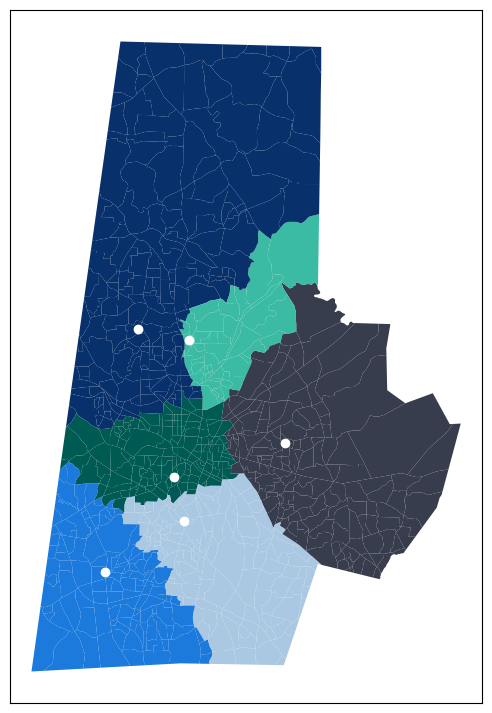

In [17]:
fig,ax = plt.subplots(figsize = (7,9))

local_hs_full_geo.plot(
    column='assign',
    ax = ax,
    cmap = best_colors,
    legend = False
)

ax.set_xticks([])
ax.set_yticks([])

#plt.title('Expanded HS Boundaries')
local_dps_base_hs.plot(ax=plt.gca(), color = 'white')
plt.savefig('even.png',dpi=600)
plt.show()

In [15]:
colors = [
    (0.667, 0.784, 0.886),  # Powder Blue     (#aad8e2)
    (0.106, 0.478, 0.859),  # Sky Blue        (#1b7ae9)
    (0.0,   0.353, 0.329),  # Deep Teal       (#005a54)
    (0.231, 0.733, 0.639),  # Light Teal      (#3bdba3)
    (0.031, 0.188, 0.419),  # Navy Blue       (#052f6b)
    (0.220, 0.239, 0.302),  # Slate Ink       (#383d4d)
]
best_colors = ListedColormap(colors)

In [2]:
scores = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\gravity_model\\gravity_model_sol.geojson')

In [3]:
scores['log_score'] = np.log(scores['score'])

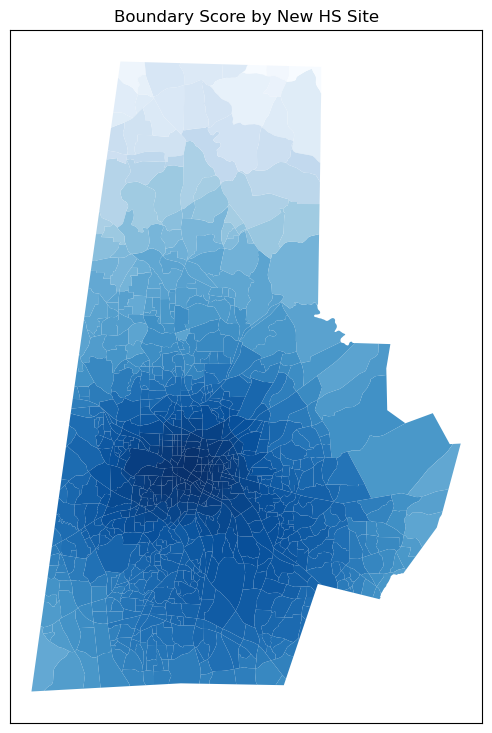

In [5]:
fig,ax = plt.subplots(figsize=(7,9))

scores.plot(
    column='log_score',
    ax = ax,
    cmap = 'Blues_r',
    legend = False
)

ax.set_xticks([])
ax.set_yticks([])

plt.title('Boundary Score by New HS Site')
plt.savefig('scores.png',dpi=600)
plt.show()